In [1]:
import time
import math
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import numpy as np
import pandas as pd
import sklearn.preprocessing as prep

Using TensorFlow backend.


In [2]:
df = pd.read_csv('btc.csv')
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2,1325318040,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
3,1325318100,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
4,1325318160,4.39,4.39,4.39,4.39,0.455581,2.0,4.39


In [3]:
def standard_scaler(X_train, X_test):
    train_samples, train_nx, train_ny = X_train.shape
    test_samples, test_nx, test_ny = X_test.shape
    
    X_train = X_train.reshape((train_samples, train_nx * train_ny))
    X_test = X_test.reshape((test_samples, test_nx * test_ny))
    
    preprocessor = prep.StandardScaler().fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    X_train = X_train.reshape((train_samples, train_nx, train_ny))
    X_test = X_test.reshape((test_samples, test_nx, test_ny))
    
    return X_train, X_test

In [7]:
def preprocess_data(btc, seq_len):
    amount_of_features = len(btc.columns)
    data = btc.as_matrix()
    
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index : index + sequence_length])
        
    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[: int(row), :]
    
    train, result = standard_scaler(train, result)
    
    X_train = train[:, : -1]
    y_train = train[:, -1][: ,-1]
    X_test = result[int(row) :, : -1]
    y_test = result[int(row) :, -1][ : ,-1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return [X_train, y_train, X_test, y_test]

In [9]:

window = 1
X_train, y_train, X_test, y_test = preprocess_data(df[:: -1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (2741269, 2, 8)
y_train (2741269,)
X_test (304585, 2, 8)
y_test (304585,)


In [11]:
def build_model(layers):
    model = Sequential()

    # By setting return_sequences to True we are able to stack another LSTM layer
    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.4))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.3))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop", metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [13]:
model = build_model([X_train.shape[2], window, 100, 1])


c:\users\aashr\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
c:\users\aashr\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 8), units=20)`
  
c:\users\aashr\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


Compilation Time :  0.5088419914245605


In [22]:
diff = []
ratio = []
pred = model.predict(X_test)

In [23]:
print(pred)

[[-0.70436215]
 [-0.70436221]
 [-0.70436221]
 ..., 
 [-0.71257228]
 [-0.71257228]
 [-0.71257228]]


In [24]:
print(y_test)

[-0.71090453 -0.71090453 -0.71090453 ..., -0.71567487 -0.71567487
 -0.71567487]


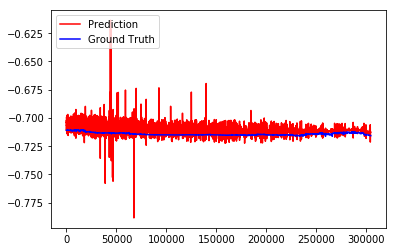

In [25]:
import matplotlib.pyplot as plt2

plt2.plot(pred, color='red', label='Prediction')
plt2.plot(y_test, color='blue', label='Ground Truth')
plt2.legend(loc='upper left')
plt2.show()

In [29]:
import time
import warnings
import numpy as np
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import matplotlib.pyplot as plt
import seaborn as sns


warnings.filterwarnings("ignore")

In [28]:
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    print('yo')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in xrange(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

In [30]:
def load_data(filename, seq_len, normalise_window):
    f = open(filename, 'r').read()
    data = f.split('\n')

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print "Compilation Time : ", time.time() - start
    return model

def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in xrange(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in xrange(len(data)/prediction_len):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in xrange(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

SyntaxError: invalid syntax (<ipython-input-30-f93fe2a9c458>, line 55)

In [33]:
 ax = sns.heatmap(pred,ytest)

NameError: name 'ytest' is not defined

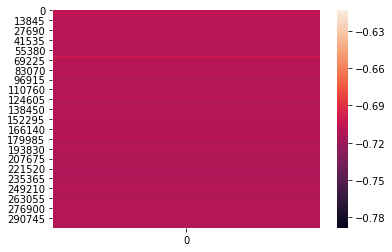

In [32]:
plt.show()